In [172]:
import torch
import torchvision
import torch.optim as optim
import argparse
import matplotlib
import torch.nn as nn
import matplotlib.pyplot as plt
import torchvision.transforms as transforms
import model
import model_conv
from tqdm import tqdm
from torchvision import datasets
from torch.utils.data import DataLoader
from torchvision.utils import save_image
matplotlib.style.use('ggplot')



In [173]:
epochs = 40
batch_size = 64
lr = 0.0001
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [174]:
# transforms
transform = transforms.Compose([
    transforms.ToTensor(),
])


In [175]:
# train and validation data
train_data = datasets.MNIST(
    root='../input/data',
    train=True,
    download=True,
    transform=transform
)
val_data = datasets.MNIST(
    root='../input/data',
    train=False,
    download=True,
    transform=transform
)

In [176]:
def create_batch(size=28, batch_size=64):
    batch = torch.zeros([batch_size,1,size,size])
    xys = torch.tensor([[0], [0]])
    xs = torch.randint(0, size, (batch_size,))
    ys = torch.randint(0, size,  (batch_size,))
    xys = torch.concatenate([xs.view(-1,1), ys.view(-1,1)], dim=1)
    batch[torch.arange(batch.shape[0]),0, xs, ys] = 1
    return batch, xys

In [177]:
model = model.LinearVAE().to(device)
optimizer = optim.Adam(model.parameters(), lr=lr)
criterion = nn.BCELoss(reduction='sum')

hej


In [178]:
def final_loss(bce_loss, mu, logvar):
    """
    This function will add the reconstruction loss (BCELoss) and the 
    KL-Divergence.
    KL-Divergence = 0.5 * sum(1 + log(sigma^2) - mu^2 - sigma^2)

    A beta here will affect how much the KLD matters

    :param bce_loss: recontruction loss
    :param mu: the mean from the latent vector
    :param logvar: log variance from the latent vector
    """
    BCE = bce_loss 
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())

    return BCE + KLD

In [179]:
def fit(model, dataloader):
    model.train()
    running_loss = 0.0
    for i in range((28*28)//batch_size):
        data = create_batch()
        data, _ = data
        data = data.to(device)
        data = data.view(data.size(0), -1)
        optimizer.zero_grad()
        reconstruction, mu, logvar = model(data)
        bce_loss = criterion(reconstruction, data)
        loss = final_loss(bce_loss, mu, logvar)
        running_loss += loss.item()
        loss.backward()
        optimizer.step()

    train_loss = running_loss/784
    return train_loss

In [184]:
def validate(model, dataloader):
    model.eval()
    running_loss = 0.0
    with torch.no_grad():
        for i in range((28*28)//batch_size):
            data = create_batch()
            data, xys = data
            data = data.to(device)
            data = data.view(data.size(0), -1)
            reconstruction, mu, logvar = model(data)
            bce_loss = criterion(reconstruction, data)
            loss = final_loss(bce_loss, mu, logvar)
            running_loss += loss.item()
        
            # save the last batch input and output of every epoch
            if ((28*28)//batch_size - 1) and (epoch % 1000 == 0):
                num_rows = 8
                both = torch.cat((data.view(batch_size, 1, 28, 28)[:8], 
                                  reconstruction.view(batch_size, 1, 28, 28)[:8]))
                save_image(both.cpu(), f"../outputs/dot_test_output{epoch}.png", nrow=num_rows)

    val_loss = running_loss/784
    return val_loss, mu, xys

In [199]:
train_loss = []
val_loss = []
for epoch in range(10001):
    print(f"Epoch {epoch+1} of {epochs}")
    train_epoch_loss = fit(model, 0)
    val_epoch_loss, mu, xys = validate(model, 0)
    train_loss.append(train_epoch_loss)
    val_loss.append(val_epoch_loss)
    print(f"Train Loss: {train_epoch_loss:.4f}")
    print(f"Val Loss: {val_epoch_loss:.4f}")

Epoch 1 of 40
Train Loss: 11.5951
Val Loss: 11.6640
Epoch 2 of 40
Train Loss: 11.7205
Val Loss: 11.5020
Epoch 3 of 40
Train Loss: 11.6467
Val Loss: 11.6636
Epoch 4 of 40
Train Loss: 12.1301
Val Loss: 11.6191
Epoch 5 of 40
Train Loss: 11.7805
Val Loss: 11.7677
Epoch 6 of 40
Train Loss: 11.6832
Val Loss: 11.5378
Epoch 7 of 40
Train Loss: 11.6166
Val Loss: 11.7569
Epoch 8 of 40
Train Loss: 11.6810
Val Loss: 11.6502
Epoch 9 of 40
Train Loss: 11.7914
Val Loss: 11.8777
Epoch 10 of 40
Train Loss: 11.7247
Val Loss: 11.6512
Epoch 11 of 40
Train Loss: 11.8759
Val Loss: 11.7443
Epoch 12 of 40
Train Loss: 11.6751
Val Loss: 11.8656
Epoch 13 of 40
Train Loss: 11.6967
Val Loss: 11.8022
Epoch 14 of 40
Train Loss: 11.8418
Val Loss: 11.7877
Epoch 15 of 40
Train Loss: 11.6086
Val Loss: 11.8959
Epoch 16 of 40
Train Loss: 11.8615
Val Loss: 11.6276
Epoch 17 of 40
Train Loss: 11.7308
Val Loss: 11.8462
Epoch 18 of 40
Train Loss: 11.8235
Val Loss: 11.8688
Epoch 19 of 40
Train Loss: 11.8657
Val Loss: 11.6730
Ep

In [27]:
print(mu[63,:])
print(xys[63,:])
# Måste generera pricka kontinuerligt annars lär den sig nog bara

tensor([-2.9210,  5.0815], device='cuda:0')
tensor([ 3, 17])


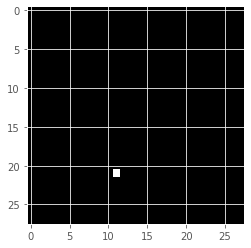

In [200]:
images, xys = create_batch()
im = images[0,0,:,:]
plt.imshow(im, cmap='gray')

In [201]:
model.eval()
im = im.to(device)
reconstruction, mu, logvar = model(im.view([1,1,-1]))


In [202]:
x = xys[0,0]
y = xys[0,1]

tensor([[2.0924, 0.4780]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor(21)
tensor(11)


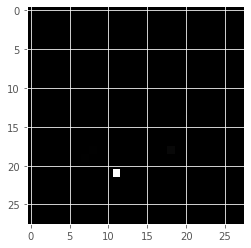

In [203]:
import numpy as np
plt.imshow(reconstruction.view(28,28).cpu().detach().numpy(), cmap='gray');
print(mu)
print(x)
print(y)


In [209]:
print(torch.exp(logvar)/2)


tensor([[1.4834e-04, 1.6405e-04],
        [7.8087e-05, 1.1400e-04],
        [5.7148e-05, 2.3025e-04],
        ...,
        [7.4143e-05, 1.8390e-04],
        [3.1704e-04, 1.8263e-04],
        [7.1270e-04, 1.4234e-03]], device='cuda:0', grad_fn=<DivBackward0>)


In [210]:
images, xys = create_batch(batch_size=700)
model.eval()
images = images.to(device)
reconstruction, mu, logvar = model(images.view(images.size(0), -1))


In [211]:
predicted = mu[:,1].cpu().detach().numpy()
x = xys[:,0]

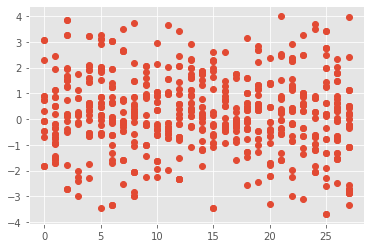

In [212]:
plt.plot(x, predicted, 'o')

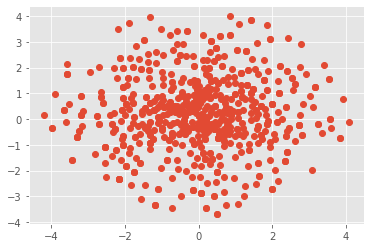

In [213]:
plt.plot(mu[:,0].cpu().detach().numpy(), mu[:,1].cpu().detach().numpy(), 'o')

In [214]:
import torch
import torch.nn as nn
import torch.nn.functional as F




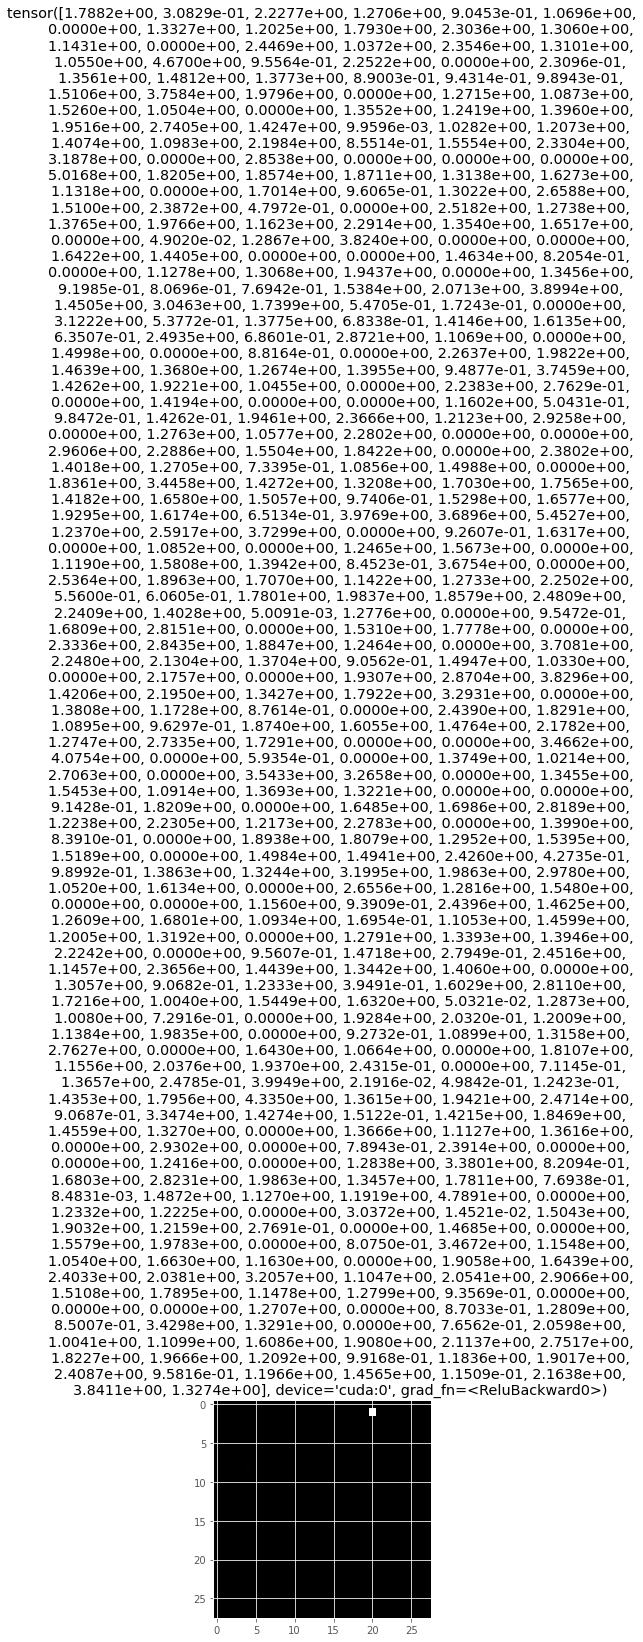

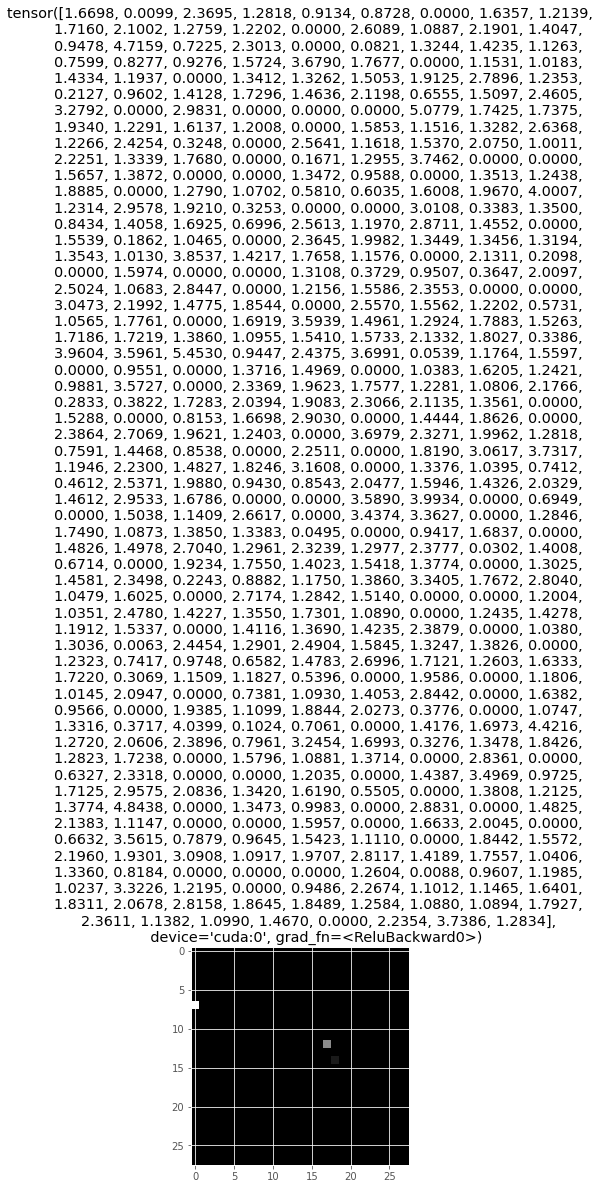

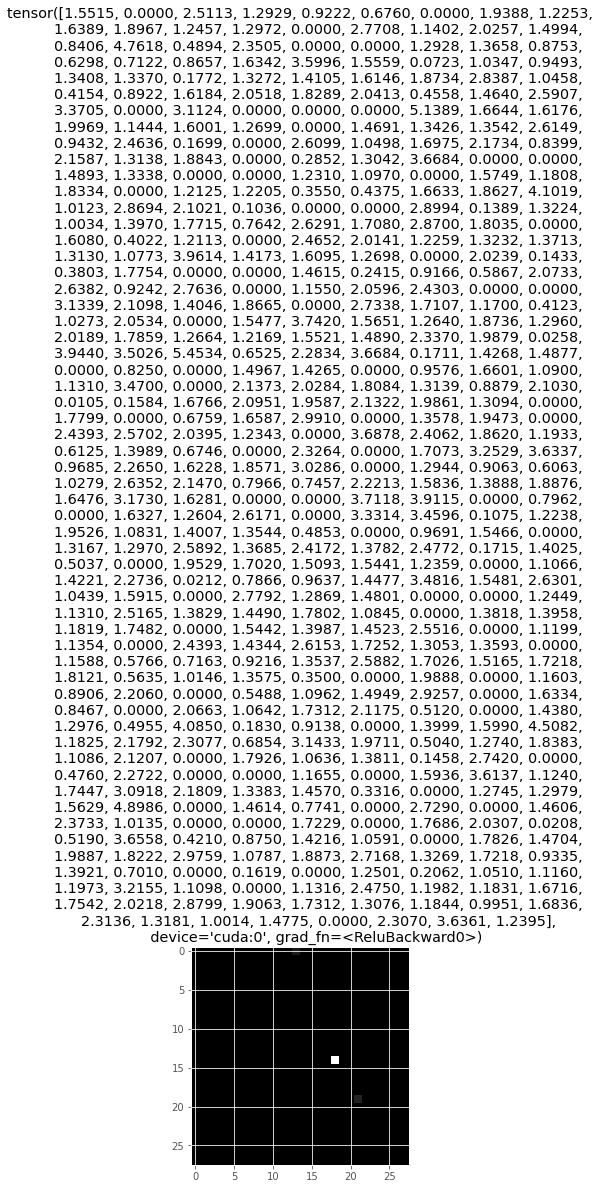

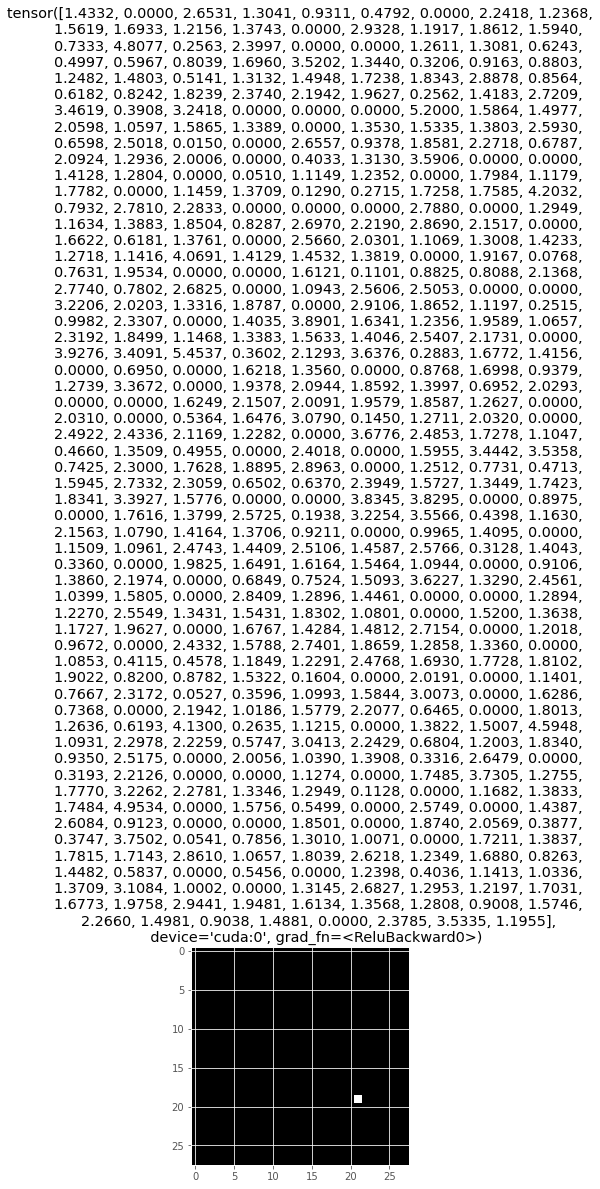

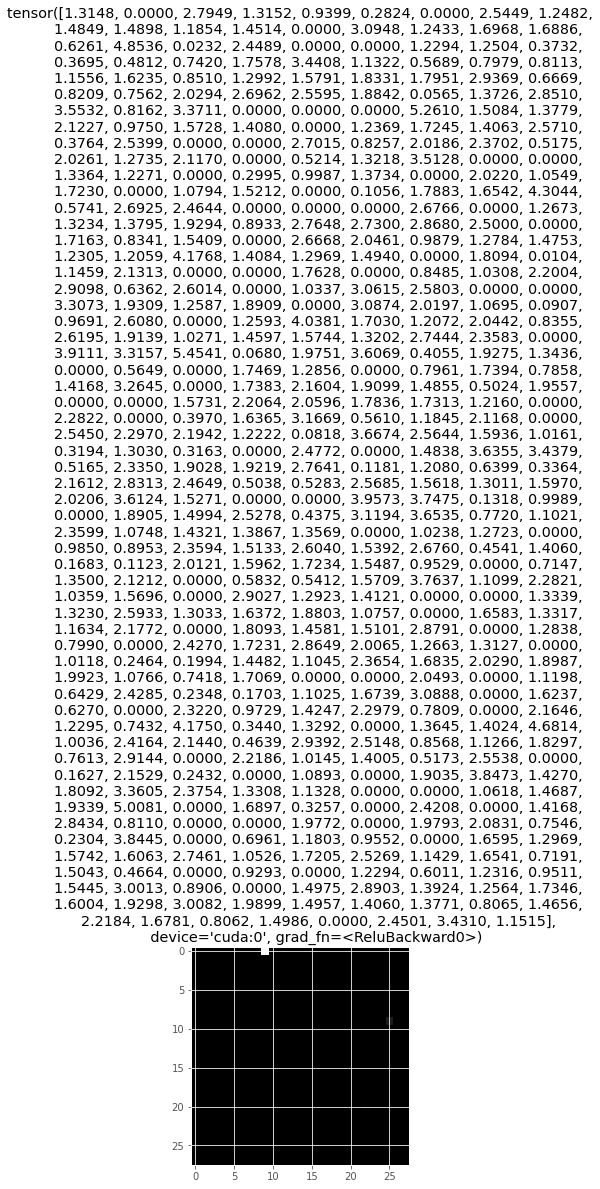

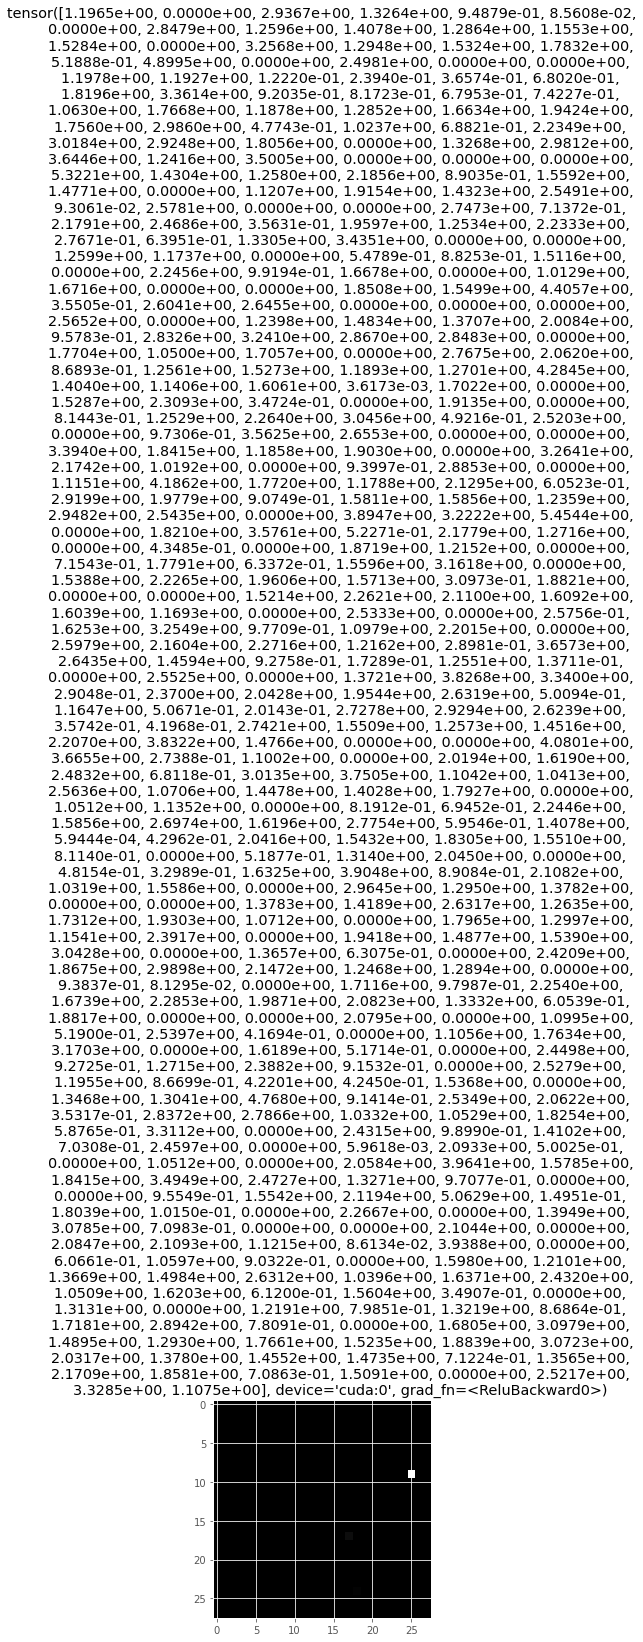

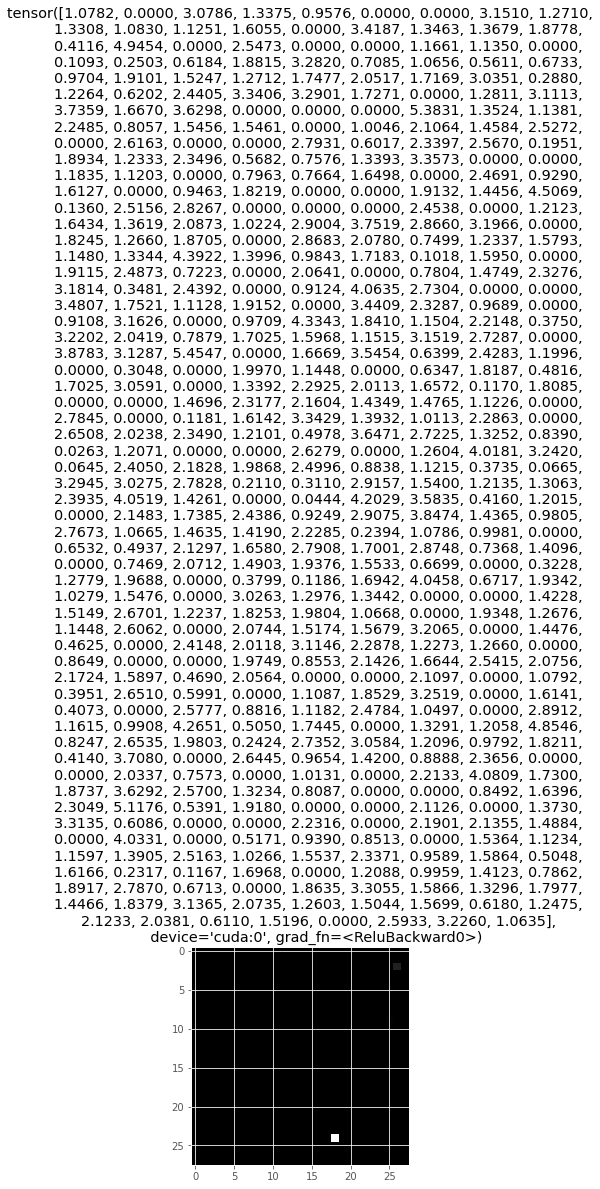

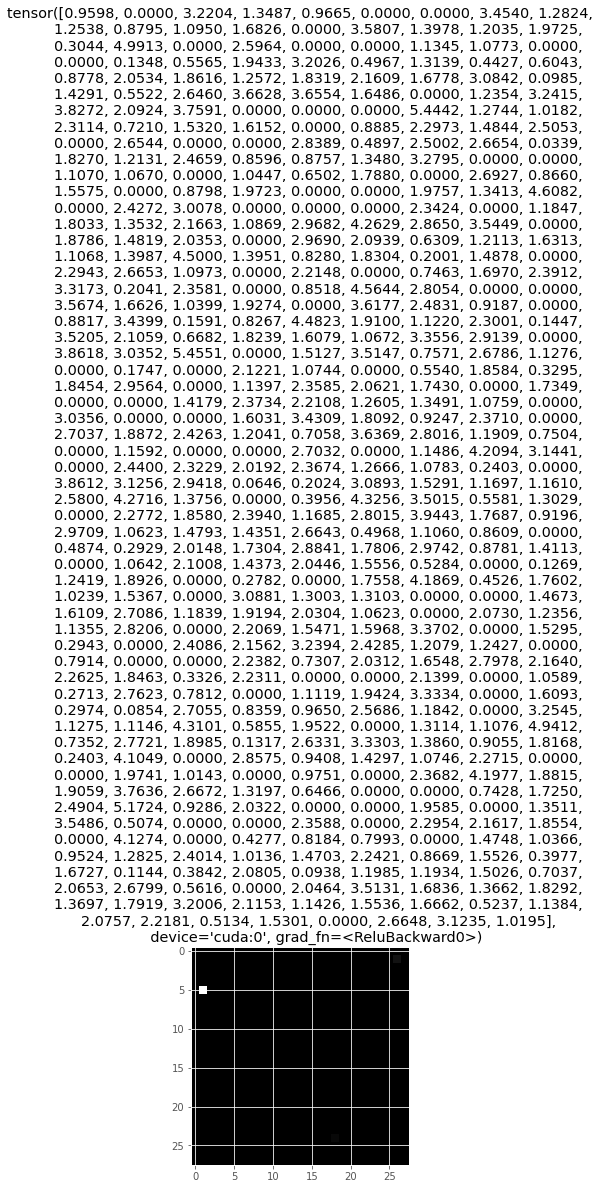

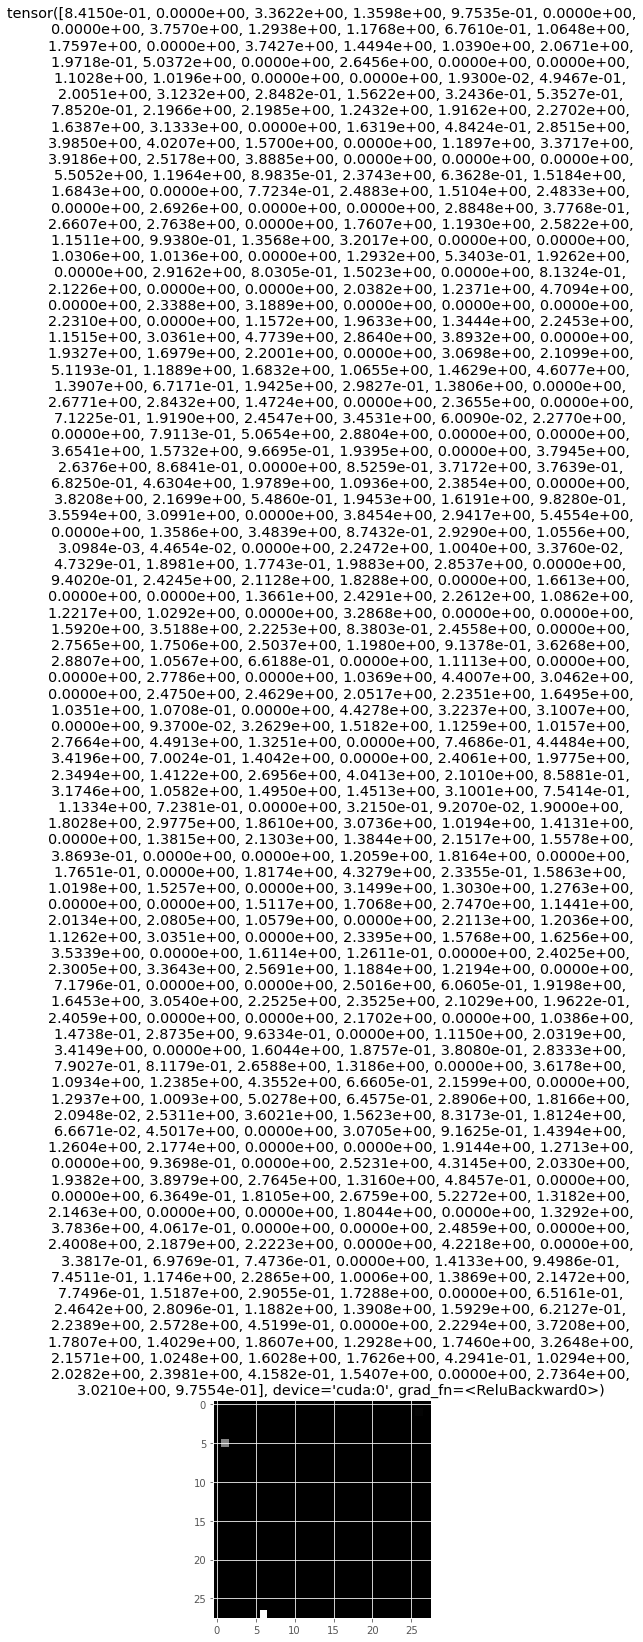

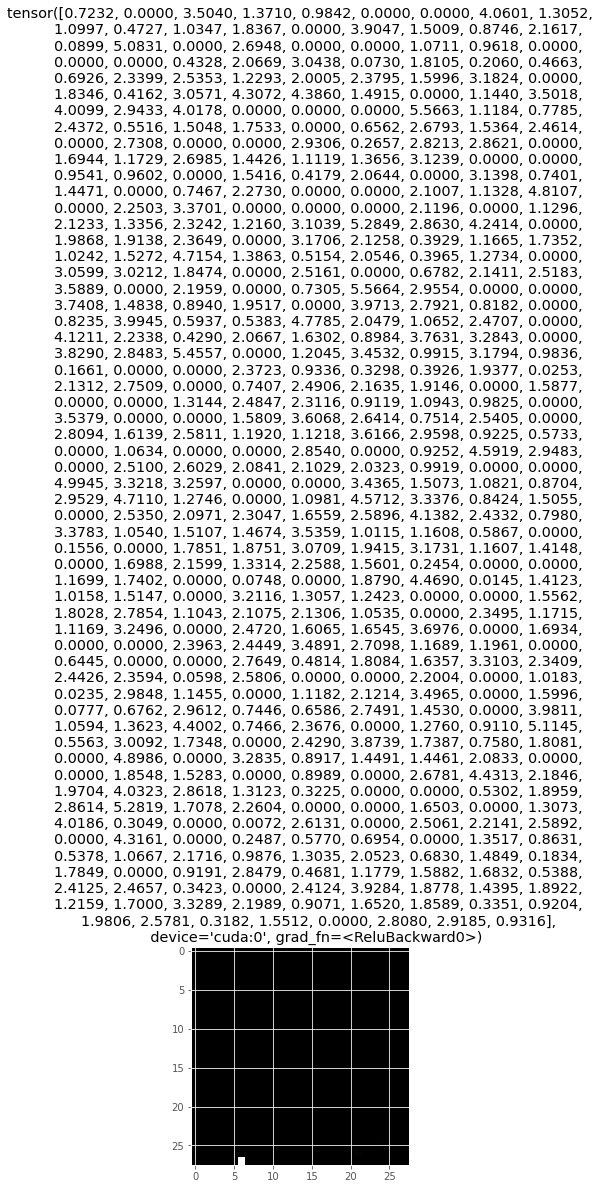

In [208]:
for x in range(0,10):
    x = x/10
    z = torch.tensor([x,0.0]).to(device);
    x = F.relu(model.dec1(z));
    test = torch.sigmoid(model.dec2(x));

    plt.imshow(test.view([28,28]).cpu().detach().numpy(), cmap='gray');
    plt.title(x);
    plt.show();